In [1]:
# 텐서플로우 디바이스 목록 출력
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13927883217577854879
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2240439910
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2583387447394531521
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
# GPU 사용
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
import numpy as np

actions = [
    'next',
    'back'
]

data = np.concatenate([
    np.load('dataset/seq_next_1682478817.npy'),
    np.load('dataset/seq_back_1682478817.npy')
], axis=0)

data.shape

(1547, 30, 100)

In [5]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1547, 30, 99)
(1547,)


In [6]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1547, 2)

In [7]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1392, 30, 99) (1392, 2)
(155, 30, 99) (155, 2)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                41984     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 44,130
Trainable params: 44,130
Non-trainable params: 0
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=300,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/300
44/44 [==============================] - ETA: 0s - loss: 0.1873 - acc: 0.9777
Epoch 1: val_acc improved from -inf to 1.00000, saving model to models\model.h5
44/44 [==============================] - 5s 18ms/step - loss: 0.1873 - acc: 0.9777 - val_loss: 0.0272 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/300
38/44 [========================>.....] - ETA: 0s - loss: 0.0144 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
44/44 [==============================] - 0s 7ms/step - loss: 0.0136 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 1.0000 - lr: 0.0010
Epoch 3/300
37/44 [========================>.....] - ETA: 0s - loss: 0.0050 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
44/44 [==============================] - 0s 7ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/300
38/44 [========================>.....] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
44/44 [==================

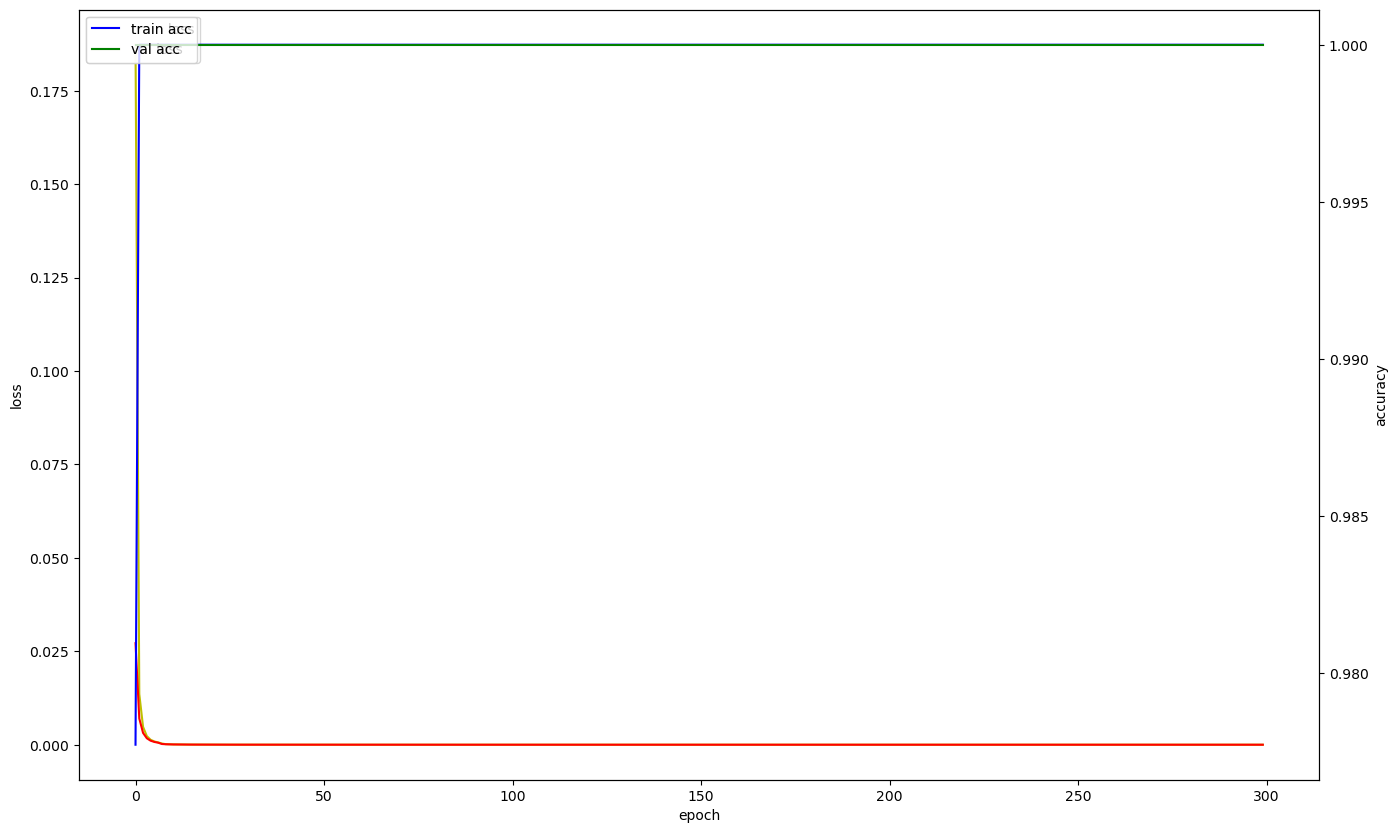

In [11]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [12]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

5/5 [==============================] - 0s 3ms/step


array([[[84,  0],
        [ 0, 71]],

       [[71,  0],
        [ 0, 84]]], dtype=int64)